# Supplemental Figure 11 — Comparison of mutation rates, positional biases, and sequencing coverage between DP6 mutagenesis and the retron-encoded DMS library
---
Unless explicitly noted otherwise (e.g. indicated as being from Zenodo), all data used for the visualisations was generated using the Illumina or Nanopore pipeline.

Please make sure to download the input dataset `Illumina` from the Zenodo repository and place it in a folder named `data` at root repository level.

For more information, please refer to the `README.md`.


### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Illumina-based analysis of mutagenesis by plLacO1-DP6</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(B)</strong>Illumina-based assessment of DMS library editing.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(C)</strong> Nanopore-based profiling
of DMS-edited phage populations.</div>  

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [10]:
# --- Import necessary modules ---
import os
import sys
import json
import pickle as pkl
from importlib import reload
from pathlib import Path

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent 
sys.path.append(str(repo_root))

import numpy as np
import pandas as pd
from Bio import SeqIO
import csv
from collections import Counter
from Bio.SeqIO import QualityIO
from scripts.utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
import matplotlib.colorbar as mcolorbar 
from scripts.Nanopore_functions import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

## Figure S11A: Illumina-based analysis of mutagenesis by plLacO1-DP6.
----------------------------
 Illumina-based analysis of mutagenesis by plLacO1-DP6. Left: Read coverage across the reference sequence (x-axis, DNA level) after filtering for quality, indels, and low coverage; y-axis shows read counts. Coverage drops toward the middle of the sequence, with an average coverage of 75.26% across the region of interest. Right: Mutation frequencies are shown per amino acid position across the AraC–AsLOV2 fusion. Each heatmap cell reflects the normalized frequency of non-reference amino acids at that position. White cells indicate reference residues or positions with read depth <2000. 


In [11]:
# ======================== ANALYSIS PARAMETERS ========================

# --- Path to input FASTQ files and config ---
homedir =  f"{repo_root}/data/Illumina/LOV_DP6_Library_Mutagenesis_10-8" 

Bc = "BC1" # Barcode to be analyzed (must match one used during demultiplexing)
read_dirs = ["R1", "R2"] # Read directions to include in the analysis
Section = "S1" # Section/amplicon to be analyzed
data_type = "AA" # Mutation type: "AA" = amino acids, "Nt" = nucleotides


all_alignments = {}

# --- Sequence region of interest ---
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()

# --- Load variant information from config ---
with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]

# ====================== LOAD AND FILTER BLAST ALIGNMENTS ======================

# --- Container to store parsed alignment and coverage data for each read direction ---
all_alignments = {}
all_coverages = {}

# --- Specify the data type to be analyzed (e.g., "AA" for amino acids) ---
data_type = "AA"

# --- Loop through both read directions: R1 and R2 ---
for read_dir in read_dirs:

    # --- Load BLAST output JSON file ---
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    # --- Load the reference DNA sequence ---
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)
    
    # --- Translate DNA reference to amino acid sequence if needed ---
    amplicon_AA = translate_dna2aa(amplicon_seq)

    # --- Extract BLAST hits from the loaded JSON ---
    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
    
    # --- Define start and end indices of the LOV2 region within the DNA reference ---
    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    # --- Filter BLAST hits: keep only those that span the LOV2 region with a ±10 nt margin ---
    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    # --- Parse and restructure alignments to extract aligned sequences and coverage data ---
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)
    
    # --- Store the results per read direction ---
    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages


# ====================== CHARACTERIZE MUTATIONAL ENRICHMENTS ======================

# --- Container for enrichment results from both read directions ---
all_enrichments = {"R1":{}, "R2":{}}

# --- Loop through each read direction (R1 and R2) ---
for read_dir in read_dirs: 

    # --- Analyze alignments: get all variant calls, indels, and enrichment metrics ---
    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)
   
    # --- Store results in a structured dictionary ---
    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

# ====================== COMBINE R1 AND R2 ENRICHMENTS ======================

# --- Set correct reference depending on analysis type ---
reference = amplicon_AA if data_type == "AA" else amplicon_seq

# --- Combine variant counts from R1 and R2 ---
total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

# --- Combine enrichment counts (mutations over wild type) ---
total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

# --- Calculate relative enrichment (mutation frequency per position) ---
total_relative_enrichment = total_enrichment/total_variants.sum()

# ====================== COMBINE INDELS ======================

# --- Sum indel counts from both read directions ---
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

# --- Calculate indel frequency using total raw coverage before filtering ---
total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

# ====================== MASK LOW-COVERAGE POSITIONS ======================

# --- Get total coverage per position ---
enrichment_coverages = total_variants.sum()

# --- Set enrichment values to NaN for positions with coverage below threshold (e.g. 2000 reads) ---
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

coverage_plot(total_variants.sum(), 
              FigFolder=None, 
              samplename = f"{variant}_{Bc}", 
              color = "#22577A")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alicehovsepyan/Documents/GitHub/pogo_pance_draft/data/Illumina/LOV_DP6_Library_Mutagenesis_10-8/config.json'

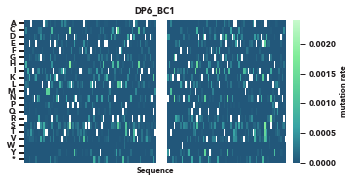

In [ ]:
plot_mutation_enrichment(total_relative_enrichment, 
                         ref_seq=reference, 
                         samplename=f"{variant}_{Bc}", 
                         data_type="AA", 
                         FigFolder=None, 
                         vmax=None, 
                         cmap = custom_cmap)

## Figure S11B: Illumina-based assessment of DMS library editing.
---------
Left: Read
coverage after quality filtering, with an average coverage of 72.84% across the region. Right:
Bottom heatmap (blue) shows observed amino acid mutation frequencies per position in the
phage population. Middle heatmap (gray) displays total mutation frequency per DNA position.
White cells indicate reference residues or positions with read depth <2000. Line plots on top
compare the relative frequency of plasmid encoded mutations (gray) versus mutations observed
in AraC-LOV phage PCR amplicons (black) per DNA residue (See methods). Shaded sections
regions intersecting the two lines highlight areas of positional bias. 

################ R1 ################
39192 alignments before filtering for LOV2 insertion site
27038 alignments after filtering for LOV2 insertion site
80 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.
################ R2 ################
37017 alignments before filtering for LOV2 insertion site
23581 alignments after filtering for LOV2 insertion site
61 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.
675 sequences with off target indels are excluded
26283 sequences are included in the enrichment analysis
943 sequences with off target indels are excluded
22577 sequences are included in the enrichment analysis


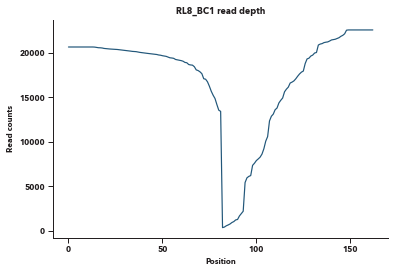

In [3]:
# ======================== ANALYSIS PARAMETERS ========================

# --- Path to input FASTQ files and config ---
homedir =  f"{repo_root}/data/Illumina/LOV_Linker_Library_Mutagenesis_10-8" 

Bc = "BC1" # Barcode to be analyzed (must match one used during demultiplexing)
read_dirs = ["R1", "R2"] # Read directions to include in the analysis
Section = "S1" # Section/amplicon to be analyzed
data_type = "AA" # Mutation type: "AA" = amino acids, "Nt" = nucleotides


all_alignments = {}

# --- Sequence region of interest ---
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()

# --- Load variant information from config ---
with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]


# ====================== LOAD AND FILTER BLAST ALIGNMENTS ======================

# --- Container to store parsed alignment and coverage data for each read direction ---
all_alignments = {}
all_coverages = {}

# --- Specify the data type to be analyzed (e.g., "AA" for amino acids) ---
data_type = "AA"

# --- Loop through both read directions: R1 and R2 ---
for read_dir in read_dirs:

    # --- Load BLAST output JSON file ---
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    # --- Load the reference DNA sequence ---
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)
    
    # --- Translate DNA reference to amino acid sequence if needed ---
    amplicon_AA = translate_dna2aa(amplicon_seq)

    # --- Extract BLAST hits from the loaded JSON ---
    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
    
    # --- Define start and end indices of the LOV2 region within the DNA reference ---
    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    # --- Filter BLAST hits: keep only those that span the LOV2 region with a ±10 nt margin ---
    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    # --- Parse and restructure alignments to extract aligned sequences and coverage data ---
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)
    
    # --- Store the results per read direction ---
    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages


# ====================== CHARACTERIZE MUTATIONAL ENRICHMENTS ======================

# --- Container for enrichment results from both read directions ---
all_enrichments = {"R1":{}, "R2":{}}

# --- Loop through each read direction (R1 and R2) ---
for read_dir in read_dirs: 

    # --- Analyze alignments: get all variant calls, indels, and enrichment metrics ---
    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)
   
    # --- Store results in a structured dictionary ---
    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

# ====================== COMBINE R1 AND R2 ENRICHMENTS ======================

# --- Set correct reference depending on analysis type ---
reference = amplicon_AA if data_type == "AA" else amplicon_seq

# --- Combine variant counts from R1 and R2 ---
total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

# --- Combine enrichment counts (mutations over wild type) ---
total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

# --- Calculate relative enrichment (mutation frequency per position) ---
total_relative_enrichment = total_enrichment/total_variants.sum()

# ====================== COMBINE INDELS ======================

# --- Sum indel counts from both read directions ---
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

# --- Calculate indel frequency using total raw coverage before filtering ---
total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

# ====================== MASK LOW-COVERAGE POSITIONS ======================

# --- Get total coverage per position ---
enrichment_coverages = total_variants.sum()

# --- Set enrichment values to NaN for positions with coverage below threshold (e.g. 2000 reads) ---
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

coverage_plot(total_variants.sum(), 
              FigFolder=None, 
              samplename = f"{variant}_{Bc}", 
              color = "#22577A")

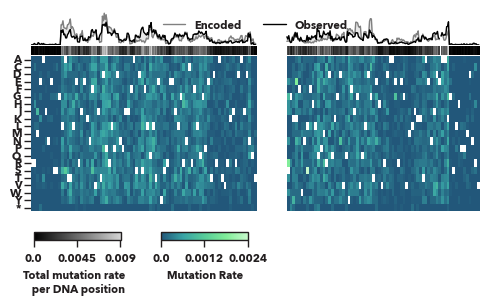

In [3]:
# ====================== LOAD RL8 DATA AND DEFINE REFERENCE SEQUENCES ======================

RL8_mutations = pd.read_csv(f"{repo_root}/final_output/Illumina/DMS_Library_Mutagenesis_10-8/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv(f"{repo_root}/final_output/Illumina/DMS_Library_Mutagenesis_10-8/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv(f"{repo_root}/final_output/Illumina/RAMPhaGE_Plasmid_Library_NGS/BC3_R1/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T


RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"

RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

# ====================== PROCESS RL8 DNA MUTATION DATA ======================

# --- Identify columns (positions) that contain only NaN values ---
# These positions likely have very low sequencing coverage and no reliable data
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]

# --- Calculate the total relative mutation rate at each position ---
RL8_DNA_muts_prop = RL8_DNA_mutations.sum()

# --- Identify and mask the position with the highest mutation rate ---
# This is likely a silent mutation (e.g. a technical artifact or contamination)
mask_max = RL8_DNA_muts_prop.idxmax()
RL8_DNA_muts_prop[mask_max] = np.nan

# --- Normalize mutation proportions across all valid positions ---
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

# --- Sum total mutation counts per position (raw, unnormalized) ---
RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()  

# --- Mask problematic positions again (masking is lost after `.sum()` operation) ---
RL8_DNA_mutations_sum[mask_max] = np.nan
RL8_DNA_mutations_sum[empty_cols] = np.nan
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop[empty_cols] = np.nan

# ====================== PROCESS RL8 ENCODED MUTATIONS ======================


# --- Cut the encoded mutation matrix to match the observed reference frame ---
# Keep only the region between cut_left and cut_right (matching the actual DNA window)
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

# --- Mask positions with low coverage (same as in the observed DNA mutations) ---
# Identify positions (columns) in the observed data that have only NaN values
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]
empty_cols = [int(empty_col) for empty_col in empty_cols]

# --- Extract encoded mutation proportions from the first row ---
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values

# --- Replace low-coverage positions and the masked maximum with NaN ---
RL8_encoded_muts_prop = pd.DataFrame([RL8_encoded_muts_prop[i] if i not in empty_cols+ [int(mask_max)] else np.nan for i in range(len(RL8_encoded_muts_prop))])


# --- Normalize the encoded mutation profile so that the sum is 1 ---
RL8_encoded_muts_prop = (RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()).values.flatten()

# ====================== PLOT ENCODED VS OBSERVED MUTATION PROFILES ======================

light_gray = "black"  # Light gray
dark_gray = "#D3D3D3"   # Dark gray

gray_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gray", [light_gray, dark_gray])


fig, axes = plt.subplots(3,1, figsize=(wi1*0.8, hi/3), height_ratios=[0.3, 0.08, 1.3])
## put plots closer together
plt.subplots_adjust(hspace=0.01)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

# --- Plot the encoded mutation profile (gray line) ---
axes[0].plot(RL8_encoded_muts_prop, label = "Encoded", linewidth = 1, color = "grey")

# --- Plot the observed mutation profile (black line) ---
axes[0].plot(RL8_DNA_muts_prop, label = "Observed", linewidth = 1, color = "black")
axes[0].set_xlim(0, len(RL8_encoded_muts.columns))
axes[0].set_ylim(0,0.012)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend(frameon = False, ncol=2)
axes[0].fill_between(range(len(RL8_encoded_muts_prop)), RL8_encoded_muts_prop, RL8_DNA_muts_prop, color= "lightgrey", alpha=0.5)

sns.heatmap(pd.DataFrame(RL8_DNA_mutations_sum).T, cmap= gray_cmap, cbar = False, ax = axes[1], xticklabels=False, yticklabels=False)


colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)
sns.heatmap(RL8_mutations, cmap= custom_cmap, cbar = False, ax = axes[2],yticklabels=True,xticklabels=False)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, fontsize = 8)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=1)
axes[2].tick_params(axis='y', pad=2)  
cbar_ax = fig.add_axes([0.13, -0.0, 0.15, 0.03])


cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax, orientation="horizontal")

ticks_gray = [0.000, 0.0045, 0.009]
cbar.set_ticks(ticks_gray)
cbar.ax.set_xticklabels([0.000, 0.0045, 0.009]) 

cbar.set_label("Total mutation rate  \n per DNA position")

cbar_ax = fig.add_axes([0.35, -0.0, 0.15, 0.03])

cbar = fig.colorbar(axes[2].collections[0], cax=cbar_ax, orientation = "horizontal")
ticks_colored = [0.0, 0.0012, 0.0024]
cbar.set_ticks(ticks_colored)
cbar.ax.set_xticklabels([0.0, 0.0012, 0.0024]) 
cbar.set_label("Mutation Rate")


# plt.savefig("final_output/RL8/RL8_encoded_vs_observed.pdf", bbox_inches='tight')
# plt.savefig("final_output/RL8/RL8_encoded_vs_observed.png", bbox_inches='tight')

plt.show()


## Figure S11C:  Nanopore-based profiling of DMS-edited phage populations.
----------------------------

Mutation frequencies per amino acid position are plotted
across the AraC-LOV sequence. White cells indicate reference residues. Cells with mutation
frequencies exceeding 0.002 are shaded in <span style="color: yellow"><b>yellow</b></span>; Due to Nanopore sequencing noise, the
frequency scale was lowered to enhance signal detection. X refers to corrected positions with
indels that would lead to a frameshift.


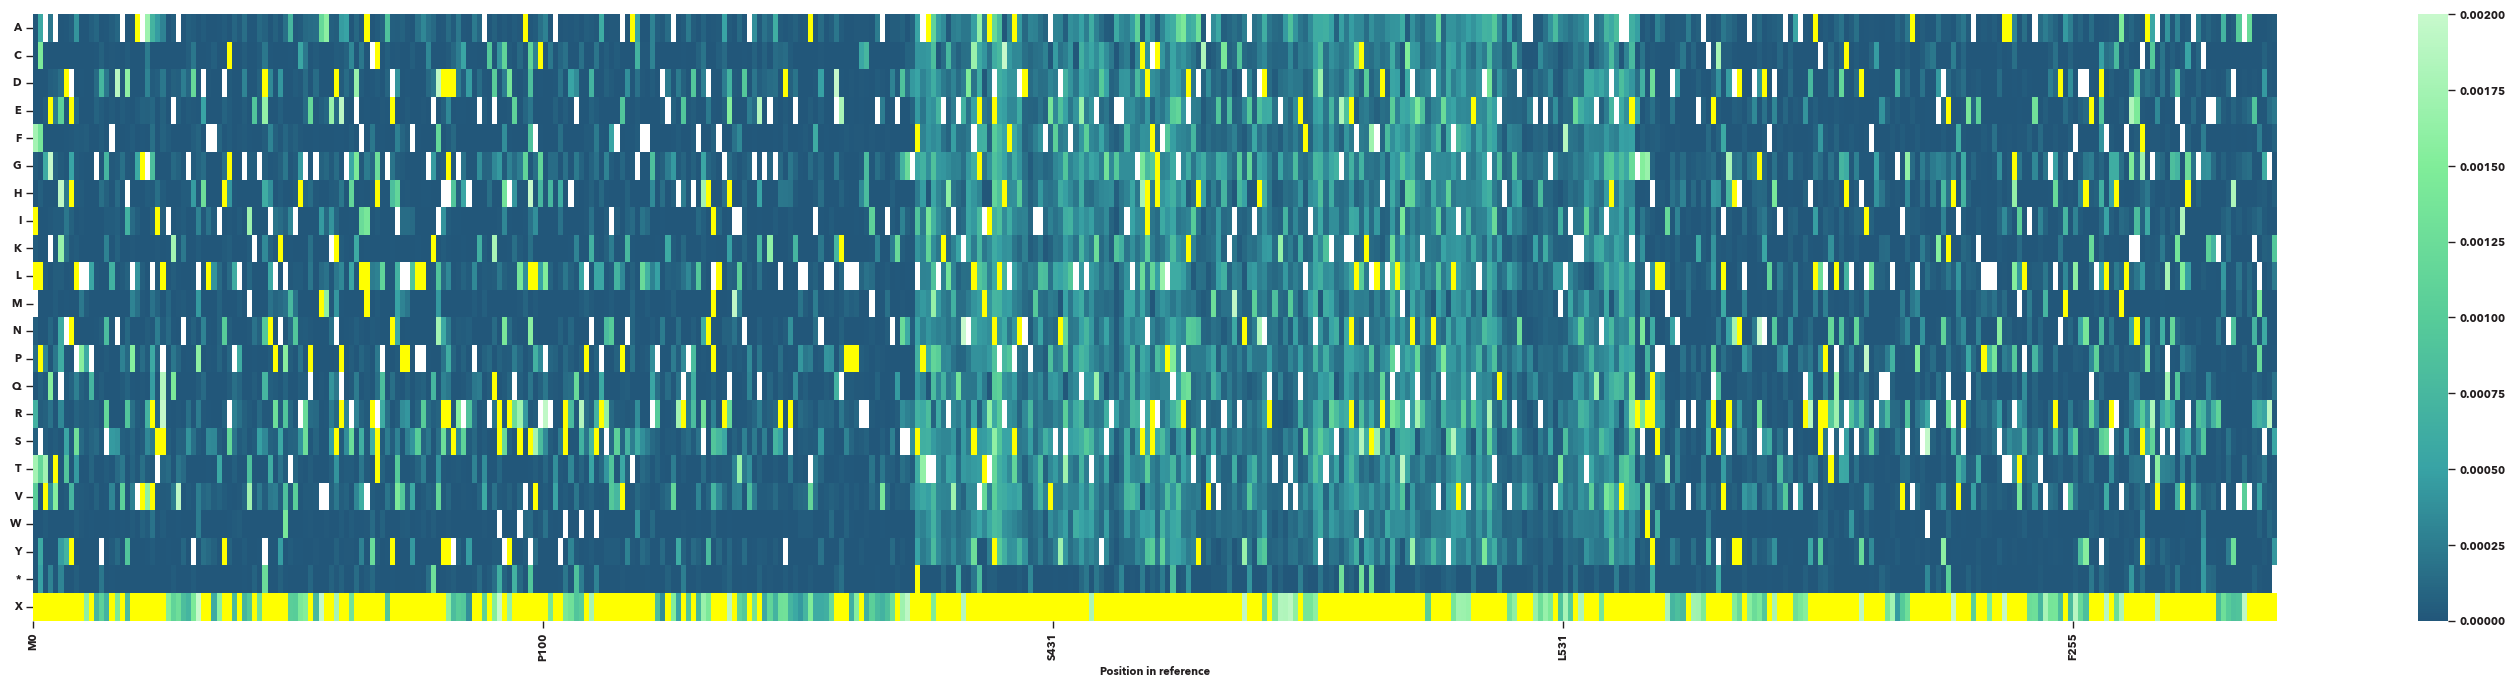

In [4]:
# --- Define input parameters and paths ---

data_folder = "Nanopore/Nanopore_P0115"
barcode = "DMS_Library_Single_Passage"
quality = 20
data_type = "AA"
FigFolder = f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/"

# --- Load mutation and enrichment data ---

all_variants = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
araclov2_enr = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)


# --- Create figure for enrichment heatmap ---

plt.figure(figsize=(wi1*5, hi))

# Use custom colormap and define color for values exceeding vmax
my_cmap = custom_cmap
my_cmap.set_over('Yellow')

# --- Plot heatmap ---
sns.heatmap(araclov2_enr, cmap=custom_cmap, xticklabels=False, yticklabels=True, vmax=0.002)
original_labels = araclov2_enr.columns
tick_positions = list(range(0, len(original_labels), 100))
tick_labels = [original_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=90)
plt.yticks(rotation = 0)

plt.xlabel("Position in reference")
# plt.savefig(f"{FigFolder}/mutation_enrichment.pdf", bbox_inches="tight", dpi=600)
# plt.savefig(f"{FigFolder}/mutation_enrichment.png", bbox_inches="tight", dpi=600)
plt.show()